In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Vehicle parameters
vehPars = {"mass": 1600,
           "l_front": 1.25,
           "l_rear": 1.45,
           "WB": 2.7,
           "Jz": 3000,
           "TrackWidth_f": 1.6,
           "TrackWidth_r": 1.6,
           "CG_Height": 0.5,
           "RCH": 0.3,
           "k_roll":0.65}   # TLLTD


In [3]:
## Tire horizontal force calculation
def HorF(f_z_fl, f_z_fr, f_z_rl, f_z_rr,alpha, Ax): # Horizontal Force
    ### tire parameters
    # c_roll:                       [-] rolling resistance coefficient
    # f_z0:                         [N] nominal normal force
    # B_front:                      [-] Coefficient B for front tire
    # C_front:                      [-] Coefficient C for front tire
    # eps_front:                    [-] load dependence of Coefficient D for front tire
    # E_front:                      [-] Coefficient E for front tire
    # B_rear:                       [-] Coefficient B for rear tire
    # C_rear:                       [-] Coefficient C for rear tire
    # eps_rear:                     [-] load dependence of Coefficient D for rear tire
    # E_rear:                       [-] Coefficient E for rear tire
    # Hint: The D parameter of the Magic Formula is determined by D = F_z * mue. mue can be set above in optim_opts_mintime!
    tire = {"c_roll": 0.013,
            "f_z0": 4000.0,
            "B_front": 8.0,
            "C_front": 2.5,
            "eps_front": -0.1,
            "E_front": 1.0,
            "B_rear": 10.0,
            "C_rear": 2.5,
            "eps_rear": -0.1,
            "E_rear": 1.0}
    vehmass = 1600
    brakebias = 0.65
    g = 9.81
    # TLLTD
    
    # longitudinal tire forces [N]
    if Ax >= 0: # RWD
        f_x_rl = 0.5 * Ax * g * vehmass
        if f_x_rl >= f_z_rl:
            f_x_rl = f_z_rl
        f_x_rr = 0.5 * Ax * g * vehmass
        if f_x_rr >= f_z_rr:
            f_x_rr = f_z_rr
        f_x_rl = min(f_x_rl, f_x_rr)
        f_x_rr = min(f_x_rl, f_x_rr)
        mu_rl = np.sqrt((f_z_rl)**2 - (f_x_rl)**2) / f_z_rl
        mu_rr = np.sqrt((f_z_rr)**2 - (f_x_rr)**2) / f_z_rr
        f_x_fl = 0
        f_x_fr = 0
        mu_fl = 1
        mu_fr = 1
        
    if Ax < 0: ## Braking
        f_x_rl = 0.5 * Ax * g * vehmass * (1-brakebias)
        if abs(f_x_rl) >= f_z_rl:
            mu_rl = 0
            f_x_rl = -f_z_rl
        else:  mu_rl = np.sqrt((f_z_rl)**2 - (f_x_rl)**2) / f_z_rl
        f_x_rr = 0.5 * Ax * g * vehmass * (1-brakebias)
        if abs(f_x_rr) >= f_z_rr:
            mu_rr = 0
            f_x_rr = -f_z_rr
        else: mu_rr = np.sqrt((f_z_rr)**2 - (f_x_rr)**2) / f_z_rr
        f_x_fl = 0.5 * Ax * g * vehmass * brakebias
        if abs(f_x_fl) >= f_z_fl:
            mu_fl = 0
            f_x_fl = -f_z_fl
        else:  mu_fl = np.sqrt((f_z_fl)**2 - (f_x_fl)**2) / f_z_fl
        f_x_fr = 0.5 * Ax * g * vehmass * brakebias
        if abs(f_x_fr) >= f_z_fr:
            mu_fr = 0
            f_x_fr = -f_z_fr
        else: mu_fr = np.sqrt((f_z_fr)**2 - (f_x_fr)**2) / f_z_fr
            
   
    
    # lateral tire forces [N]
    f_y_fl = (mu_fl * f_z_fl * (1 + tire["eps_front"] * f_z_fl / tire["f_z0"])
              * math.sin(tire["C_front"] * math.atan(tire["B_front"] * alpha[0] - tire["E_front"]
                                                 * (tire["B_front"] * alpha[0] - math.atan(tire["B_front"] * alpha[0])))))
    f_y_fr = (mu_fr * f_z_fr * (1 + tire["eps_front"] * f_z_fr / tire["f_z0"])
              * math.sin(tire["C_front"] * math.atan(tire["B_front"] * alpha[1] - tire["E_front"]
                                                 * (tire["B_front"] * alpha[1] - math.atan(tire["B_front"] * alpha[1])))))
    f_y_rl = (mu_rl * f_z_rl * (1 + tire["eps_rear"] * f_z_rl / tire["f_z0"])
              * math.sin(tire["C_rear"] * math.atan(tire["B_rear"] * alpha[2] - tire["E_rear"]
                                                * (tire["B_rear"] * alpha[2] - math.atan(tire["B_rear"] * alpha[2])))))
    f_y_rr = (mu_rr * f_z_rr * (1 + tire["eps_rear"] * f_z_rr / tire["f_z0"])
              * math.sin(tire["C_rear"] * math.atan(tire["B_rear"] * alpha[3] - tire["E_rear"]
                                                * (tire["B_rear"] * alpha[3] - math.atan(tire["B_rear"] * alpha[3])))))
    # Total Fx
    Fx =(f_x_fl + f_x_fr) * math.cos(deltaW) + f_x_rl + f_x_rr + (-f_y_fl - f_y_fr) * math.sin(deltaW)
    
    # Total Fy
    Fy = (f_y_fl + f_y_fr) * math.cos(deltaW) + f_y_rl + f_y_rr + (-f_x_fl - f_x_fr) * math.sin(deltaW)    
    
    return [[f_x_fl, f_x_fr, f_x_rl, f_x_rr], [f_y_fl, f_y_fr, f_y_rl, f_y_rr], Fx, Fy]


## Wheel loads after lateral load transfer
def llt(vehPars: dict, deltaW, fy: list, fx:list):
    g = 9.81
    # Total Fx
    Fx =(fx[0] + fx[1]) * math.cos(deltaW) + fx[2] + fx[3] + (-fy[0] - fy[1]) * math.sin(deltaW)
    
    # Total Fy
    Fy = (fy[0] + fy[1]) * math.cos(deltaW) + fy[2] + fy[3] + (-fx[0] - fx[1]) * math.sin(deltaW)
    
    #   Load Transfer Model
    # static normal tire forces [N]
    f_zstat_fl = 0.5 * vehPars["mass"] * g * vehPars["l_rear"] / vehPars["WB"]
    f_zstat_fr = 0.5 * vehPars["mass"] * g * vehPars["l_rear"] / vehPars["WB"]
    f_zstat_rl = 0.5 * vehPars["mass"] * g * vehPars["l_front"] / vehPars["WB"]
    f_zstat_rr = 0.5 * vehPars["mass"] * g * vehPars["l_front"] / vehPars["WB"]

#     # dynamic normal tire forces (aerodynamic downforces) [N]
#     f_zlift_fl = 0.5 * veh["liftcoeff_front"] * v ** 2
#     f_zlift_fr = 0.5 * veh["liftcoeff_front"] * v ** 2
#     f_zlift_rl = 0.5 * veh["liftcoeff_rear"] * v ** 2
#     f_zlift_rr = 0.5 * veh["liftcoeff_rear"] * v ** 2

    # dynamic normal tire forces (load transfers) [N]
    f_zdyn_fl = vehPars["CG_Height"] * (-0.5 / vehPars["WB"] * Fx - vehPars["k_roll"] * Fy / vehPars["TrackWidth_f"])
    f_zdyn_fr = vehPars["CG_Height"] * (-0.5 / vehPars["WB"] * Fx + vehPars["k_roll"] * Fy / vehPars["TrackWidth_f"])
    f_zdyn_rl = vehPars["CG_Height"] * ( 0.5 / vehPars["WB"] * Fx - (1.0 - vehPars["k_roll"]) * Fy / vehPars["TrackWidth_r"])
    f_zdyn_rr = vehPars["CG_Height"] * ( 0.5 / vehPars["WB"] * Fx + (1.0 - vehPars["k_roll"]) * Fy / vehPars["TrackWidth_r"])

    # sum of all normal tire forces [N]
    f_z_fl = f_zstat_fl + f_zdyn_fl
    f_z_fr = f_zstat_fr + f_zdyn_fr
    f_z_rl = f_zstat_rl + f_zdyn_rl
    f_z_rr = f_zstat_rr + f_zdyn_rr
    
    return [f_z_fl, f_z_fr, f_z_rl, f_z_rr]

## Kinematics 
def slipangle(deltaW, v, beta, vehPars: dict, omega_z):
    alpha[0] = deltaW - math.atan((v * math.sin(beta) + vehPars["l_front"] * omega_z) /
                                   (v * math.cos(beta) - 0.5 * vehPars["TrackWidth_f"] * omega_z))
    alpha[1] = deltaW - math.atan((v * math.sin(beta) + vehPars["l_front"] * omega_z) /
                                   (v * math.cos(beta) + 0.5 * vehPars["TrackWidth_f"] * omega_z))
    alpha[2] = math.atan((-v * math.sin(beta) + vehPars["l_rear"] * omega_z) /
                           (v * math.cos(beta) - 0.5 *vehPars["TrackWidth_r"] * omega_z))
    alpha[3] = math.atan((-v * math.sin(beta) + vehPars["l_rear"] * omega_z) /
                           (v * math.cos(beta) + 0.5 * vehPars["TrackWidth_r"] * omega_z))
    return alpha

Text(0.5, 0, 'Ay [g]')

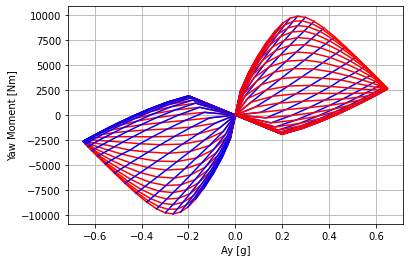

In [8]:
#### Yaw Moment Diagramm
Fy = np.zeros(4)
Fz = np.zeros(4)
alpha = np.zeros(4)

v = 50 # Forward speed [m/s]

Ax = 0.8 # -0.8 is not working well with current calculation parameters
omega_z = 0
cnt1 = 0
Mz = np.zeros([25, 25])
Fy_tot = np.zeros([25, 25])
beta_Rng = np.linspace(-6, 6, num=25)
deltaW_Rng = np.linspace(-6, 6, num=25)
for beta in beta_Rng:
    cnt2 = 0
    beta = beta * np.pi/ 180
#     Fz = llt(vehPars, deltaW, Fy, Fx)
    for deltaW in deltaW_Rng:
        deltaW = deltaW * np.pi/ 180
        Fz[0] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
        Fz[1] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
        Fz[2] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
        Fz[3] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
        omega_z = 0
        alpha = slipangle(deltaW, v, beta, vehPars, omega_z)
        FxFy = HorF(Fz[0], Fz[1], Fz[2], Fz[3],alpha, Ax)
        Fx = FxFy[0]
        while True:
            Fy = FxFy[1]
#             print("F_y_rr = ", FxFy[1][3])
#             print("F_x_rr = ", FxFy[0][3])
#             print("F_z_rr = ", Fz[3])
            Fz += 0.1*(llt(vehPars, deltaW, Fy, Fx)-Fz)
#             Fz = llt(vehPars, deltaW, Fy, Fx)
            if min(Fz) < 0:
                print("Wheel lifted")
            FxFy = HorF(Fz[0], Fz[1], Fz[2], Fz[3],alpha, Ax)
            Fx = FxFy[0]
            Fy = FxFy[1]
            Fy0 = FxFy[3]
            omega_z += 0.1*(FxFy[3] / vehPars["mass"] / v - omega_z)
            alpha = slipangle(deltaW, v, beta, vehPars, omega_z)
            FxFy = HorF(Fz[0], Fz[1], Fz[2], Fz[3],alpha, Ax)
            Fx = FxFy[0]
#             Fy = FxFy[1]
#             print(abs(sum(FxFy[1]) - sum(Fy)))
#             if (abs(sum(FxFy[1]) - sum(Fy)) < 0.001): break
            if ((FxFy[3] - Fy0)**2 < 1e-9): break
#         print("alpha_fl = ", Fy)
        Mz[cnt1][cnt2] = (Fy[0] + Fy[1]) * math.cos(deltaW) * vehPars["l_front"] - (Fy[2] + Fy[3]) * vehPars["l_rear"] # need to add Fx to this
        Fy_tot[cnt1][cnt2] = FxFy[3] / vehPars["mass"] / 9.81
        cnt2 += 1
    cnt1 += 1

for i in range(25):
    plt.plot(Fy_tot[i], Mz[i],color='blue')
    plt.plot(Fy_tot.T[i], Mz.T[i],color='red')
plt.grid()
plt.ylabel('Yaw Moment [Nm]')
plt.xlabel('Ay [g]')

Text(0.5, 0, 'Ay [g]')

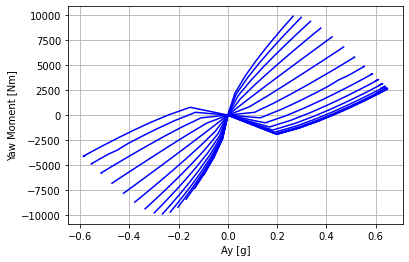

In [7]:
for i in range(17):
    plt.plot(Fy_tot[i], Mz[i],color='blue')
#     plt.plot(Fy_tot.T[i], Mz.T[i],color='red')
plt.grid()
plt.ylabel('Yaw Moment [Nm]')
plt.xlabel('Ay [g]')

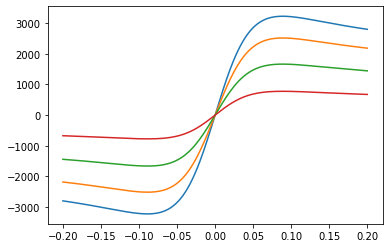

In [45]:
# Check MF
Fz[0] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
Fz[1] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
Fz[2] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
Fz[3] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
for Ax in [0.1, 0.3, 0.4, 0.45]:
    F = []
    for alpha in np.linspace(-0.2, 0.2, num=250):
        F.append(HorF(Fz[0], Fz[1], Fz[2], Fz[3],[alpha, alpha, alpha, alpha],Ax)[1][2])
    plt.plot(np.linspace(-0.2, 0.2, num=250), F)